<h1> GAN-Based Application </h1>

<h2> by Nathan Dilla & John Haviland </h2>


<h3> GAN Background </h3>

Generative Adversarial Networks (GANs) are a class of artificial intelligence algorithms introduced by Ian Goodfellow and his colleagues in 2014. GANs consist of two neural networks—the generator and the discriminator—engaged in a competitive game framework. The generator aims to produce synthetic data that is indistinguishable from real data, while the discriminator's role is to differentiate between real and fake data generated by the generator. Through adversarial training, where these networks compete and improve simultaneously, GANs have demonstrated remarkable success in generating realistic images, music, text, and more. Their ability to create new, realistic data has found applications in various fields, including image generation, style transfer, and data augmentation. <br>

<h3> Problem Statement </h3>

The rise of artificially-created images on social media and the Internet in general leads to a need in understanding how this comes to be. In this project, we set out to try and recreate images of goats using a Kaggle dataset and a Generative Adversatial Network that we created. <br>

<h3> Dataset Overview </h3>

This program creates a Generative Adversarial Network to generate pictures of goat faces. <br> 
The dataset contains nearly 2,000 pictures of goat faces. <br>
Source Link: https://www.kaggle.com/datasets/divyansh22/sheep-breed-classification <br>

<h3> Implementation </h3>

<h4> Step 1: Import Necessary Libraries </h4>

In this step, we import essential libraries and frameworks required for building and training the GAN. Each library serves a specific purpose in the development and execution of the GAN: <br>

- TensorFlow: An open-source deep learning framework used for building neural networks and executing machine learning algorithms efficiently. <br>
- NumPy: A library for numerical computations in Python, extensively used for handling arrays and mathematical operations. <br>
- Python Imaging Library (PIL): Used for image processing tasks like opening, manipulating, and saving many different image file formats. <br>
- Tqdm: A utility for displaying progress bars during iterations or loops, helpful for tracking training progress. <br>
- Matplotlib: A comprehensive library for creating static, interactive, and animated visualizations in Python, often used here for displaying and saving generated images. <br>



In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam

import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

<h4> Step 2: Configuration Setup & Data Preparation </h4>

The following code block initializes various parameters and prepares the dataset for training the Generative Adversarial Network (GAN).

- Generation Parameters: Defines factors and dimensions for generating images, along with the number of image channels.
- Preview Configuration: Specifies the number of preview rows and columns for displaying sample images during training, as well as the margin between preview images.
- Seed Size: Sets the size of the seed vector used for generating images to ensure consistency.
- Data Path and Training Parameters: Specifies the path to the dataset and sets the number of epochs, batch size, and buffer size for shuffling data during training.

A helper function `hms_string()` is included to convert elapsed time in seconds to a readable format (hours:minutes:seconds).

The code checks for the existence of a preprocessed training data file. If it doesn't exist, it loads images from the specified dataset path, resizes them to the defined square dimensions, and preprocesses them into a format suitable for GAN training:

1. Loading Images: Images are loaded from the dataset directory and resized using Lanczos resampling to match the specified square dimensions.
2. Data Normalization: The loaded images are reshaped, converted to float32 format, and normalized to values between -1 and 1.
3. Saving Preprocessed Data: The preprocessed training image data is saved into a binary file for future use.

Finally, the code creates a TensorFlow `Dataset` object from the processed training data. This dataset is shuffled and batched based on the defined batch size and buffer size, ready for training the GAN model.

In [2]:
GENERATE_RES = 4 
GENERATE_SQUARE = 32 * GENERATE_RES
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Data configuration
DATA_PATH = "sheep" # path to the dataset
EPOCHS = 500
BATCH_SIZE = 32 
BUFFER_SIZE = 60000
SEED_SIZE = 100

print(f"Will generate {GENERATE_SQUARE}px square images.")

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.Resampling.LANCZOS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training.")
  training_data = np.load(training_binary_path)

# Shuffle the dataset
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Will generate 128px square images.
Looking for file: sheep/training_data_128_128.npy
Loading previous training pickle...


<h4> Step 3: Build Generator & Discriminator Models </h4>


<h5> Generator Model </h5> 

The `build_generator(seed_size, channels)` function constructs the generator neural network responsible for creating synthetic images. It follows these key steps:

1. Input Layer: Takes a seed vector of size `seed_size` as input.
2. Dense Layer: Utilizes a dense layer with Swish activation to transform the seed vector into a dense representation suitable for reshaping.
3. Reshape Layer: Reshapes the dense representation into a 4x4x256 tensor.
4. Upsampling and Convolution Layers: Successively applies upsampling and convolutional layers with batch normalization and Swish activation. This helps increase the spatial dimensions and complexity of the generated image.
5. Final Convolutional Layer: Concludes with a convolutional layer producing the output image channels using the hyperbolic tangent (tanh) activation function, ensuring pixel values are in the range [-1, 1]. 

<h5> Discriminator Model </h5>

The `build_discriminator(image_shape)` function constructs the discriminator neural network, which evaluates whether an input image is real or generated:

1. Convolutional Layers: Begins with convolutional layers followed by LeakyReLU activations, aimed at learning hierarchical features from input images.
2. Dropout Layers: Introduces dropout to prevent overfitting and improve generalization.
3. Batch Normalization: Applies batch normalization to stabilize and accelerate training by normalizing the activations.
4. Flatten and Dense Layer: Flattens the final convolutional layer's output and feeds it into a dense layer with a sigmoid activation, producing a single output indicating the probability of the input image being real.

Both models are integral parts of the GAN architecture, with the generator creating synthetic images and the discriminator distinguishing between real and fake images. These models work in tandem, competing and improving iteratively during GAN training.

In [3]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="swish",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("swish"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("swish"))
   
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("swish"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("swish"))

    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


<h4> Step 4: Training Loop & Utilities </h4>

<h5> Image Saving Utility `save_images(cnt, noise)` </h5>

This function generates and saves images during training for visualization purposes:

- Image Array Initialization: Initializes an array to store the generated images in a grid layout.
- Generating Images: Uses the generator model to create synthetic images from random noise (`noise`) using `generator.predict()`.
- Normalization: Normalizes the generated images to the range [0, 255].
- Arranging Images: Places the generated images into the image array in a grid pattern.
- Saving Images: Saves the arranged images in a PNG file named according to the training iteration (`cnt`) in the specified output path.

<h5> Generator and Discriminator Initialization </h5>

- Generator Initialization: Builds the generator model using the defined `build_generator()` function with the specified seed size and image channels.
- Random Noise Generation: Generates random noise using TensorFlow's `tf.random.normal()` to create an initial generated image for preview.
- Discriminator Initialization: Builds the discriminator model using the defined `build_discriminator()` function, specifying the image shape.

<h5> Loss Functions and Optimizers </h5>

Defines the loss functions and optimizers for the generator and discriminator:

- Binary Cross Entropy: Defines the loss function using binary cross-entropy, a common choice for GANs.
- Loss Functions: Provides functions for calculating discriminator and generator losses based on real and fake outputs.
- Optimizers: Configures Adam optimizers for both the generator and discriminator models.

<h5> Training Step and Training Loop </h5>

Defines the `train_step()` function and initiates the training loop:

- `train_step()` Function: Performs a single training step using gradient tape to compute gradients and update the generator and discriminator weights based on their respective losses.

- `train()` Function: Initiates the training loop for the specified number of epochs. In each epoch, it iterates through the dataset batches, calculates generator and discriminator losses, updates the models, and saves generated images for visualization.

- Elapsed Time: Prints the training time and epoch-wise generator and discriminator losses for monitoring training progress.

This code section encompasses the complete training process of the GAN model, including the training loop, loss calculations, and image generation for visualization.

tf.Tensor([[0.49994898]], shape=(1, 1), dtype=float32)


2023-11-24 18:44:32.346446: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Epoch 1, gen loss=1.0620028972625732,disc loss=2.2485079765319824, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 444ms/step
Epoch 2, gen loss=0.9524788856506348,disc loss=2.0992393493652344, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 215ms/step
Epoch 3, gen loss=0.9451339244842529,disc loss=2.333050489425659, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 207ms/step
Epoch 4, gen loss=1.1110365390777588,disc loss=2.1914737224578857, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 200ms/step
Epoch 5, gen loss=1.2914940118789673,disc loss=2.041080951690674, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 194ms/step
Epoch 6, gen loss=1.1906133890151978,disc loss=1.811103105545044, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 202ms/step
Epoch 7, gen loss=1.0277849435806274,disc loss=1.918655514717102, {hms_string(epoch_elapsed)}
1/1 [================

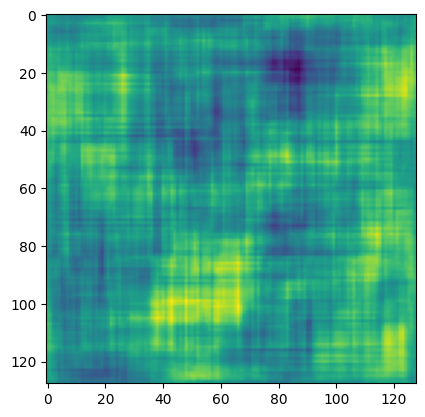

In [4]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.0e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.0e-4,0.5)

@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

---

<h4> Step 5: Visualizing Generated Images at Different Epochs </h4>


The code section loads and displays generated images at various epochs during the training process of the Generative Adversarial Network (GAN). Each block follows a similar structure:

<h5> Load and Display Image for Specific Epoch </h5>

- Load Image: Loads the image corresponding to a specific epoch using `Image.open()` and assigns it to a variable (`image`).
- Plot Image: Uses Matplotlib's `plt.imshow()` function to display the loaded image.
- Optional Axis Settings: The optional `plt.axis('off')` line removes the axis if needed.
- Title: Sets a title for the displayed image, indicating the epoch number.

<h5> Epoch-Specific Image Visualization </h5>

The provided code includes image visualization for various epochs, showcasing the progression of generated images as the GAN undergoes training:

1. Epoch 1: Displays the image generated after the first epoch.
2. Epoch 50: Displays the image generated after 50 epochs.
3. Epoch 100: Displays the image generated after 100 epochs.
4. Epoch 200: Displays the image generated after 200 epochs.
5. Epoch 400: Displays the image generated after 400 epochs.
6. Epoch 500: Displays the final image generated after 500 epochs.

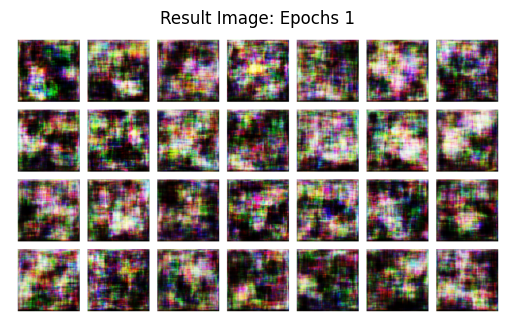

In [11]:
# Load an image
data1 = 'sheep/output/train-1.png'
image = Image.open(data1)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title("Result Image: Epochs 1")
plt.show()

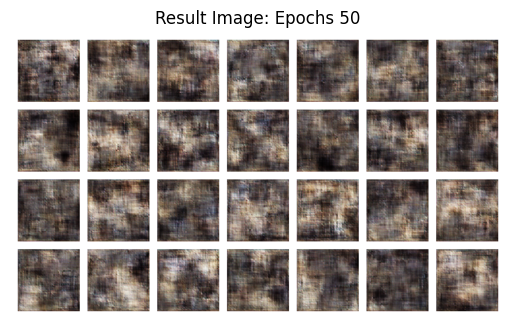

In [12]:
# Load an image
data2 = 'sheep/output/train-50.png'
image = Image.open(data2)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title("Result Image: Epochs 50")
plt.show()

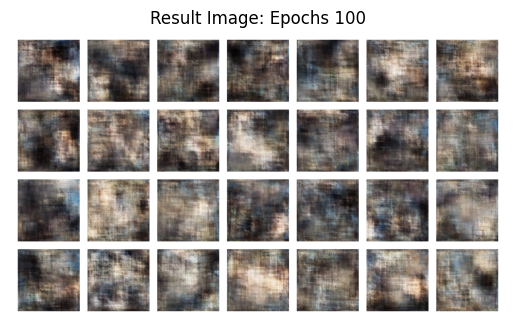

In [24]:
# Load an image
data3 = 'sheep/output/train-100.png'
image = Image.open(data3)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title("Result Image: Epochs 100")
plt.show()

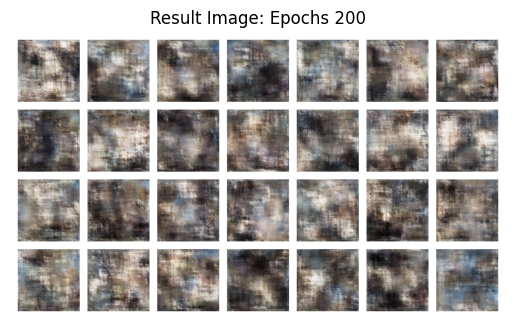

In [25]:
# Load an image
data4 = 'sheep/output/train-200.png'
image = Image.open(data4)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title("Result Image: Epochs 200")
plt.show()

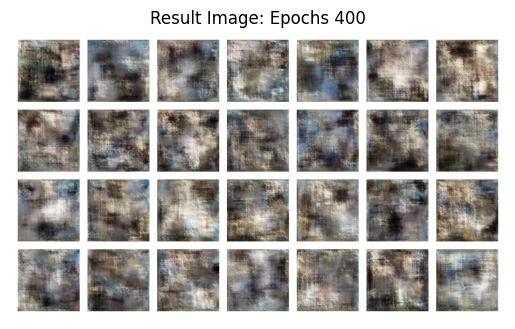

In [28]:
# Load an image
data5 = 'sheep/output/train-400.png'
image = Image.open(data5)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title("Result Image: Epochs 400")
plt.show()

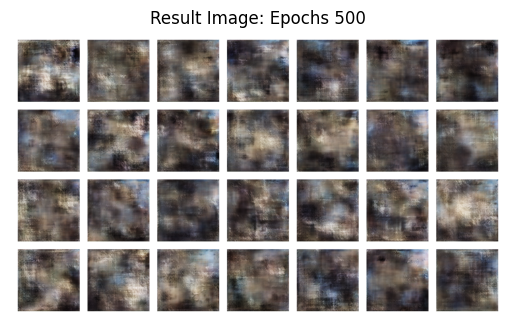

In [30]:
# Load an image
data6 = 'sheep/output/train-499.png'
image = Image.open(data6)

# Plot the image
plt.imshow(image)
plt.axis('off')
plt.title("Result Image: Epochs 500")
plt.show()

<h3> Observations </h3>

The GAN from epoch 1 to epoch 50 shows significant improvement, as the common colors found in the goat face dataset start to show. Epoch 50 to epoch 100 and to epoch 200 start to show more and more detail into the commonalities of the goat faces in the dataset. After this however, the difference in change starts to become minimal.

While we were impressed in our GAN's performance, the end result did not give us images of goat faces that could realistically be mixed up by the images in the dataset by a person.


<h3> How We Could Improve The GAN </h3>

1. Architecture Modifications:
    - Deeper Networks: Increase network depth for capturing more complex features.
    - Residual Connections: Incorporate skip connections to aid training stability.
    - Attention Mechanisms: Implement attention mechanisms for focusing on crucial image regions.

2. Loss Function Adjustments:
    - Different Loss Functions: Experiment with alternative loss functions like Wasserstein loss or hinge loss.
    - Feature Matching Loss: Match statistics between real and generated images at intermediate layers for better fidelity.

3. Regularization Techniques**:
    - Gradient Penalty: Apply methods like WGAN-GP to enforce Lipschitz constraint on the discriminator.
    - Noise Regularization: Add noise to inputs or intermediate layers to prevent mode collapse.

4. Data Augmentation:
    - Augmented Training Data: Diversify training data using augmentation techniques (rotation, scaling, etc.) for better generalization.

5. Advanced Architectures:
    - Conditional GANs: Enable control over generated output by conditioning on specific attributes.
    - StyleGAN: Adopt architectures like StyleGAN or StyleGAN2 for better control over image styles.

6. Hyperparameter Tuning:
    - Learning Rate Scheduling: Employ dynamic learning rate schedules or cyclic learning rates.
    - Batch Size Adjustment: Experiment with different batch sizes for improved stability.

7. Evaluation and Monitoring:
    - Inception Score and FID: Calculate metrics for quantitative evaluation of image quality and diversity.
    - Visual Inspection and Human Feedback: Regularly review generated images and seek human feedback for improvement guidance.

8. Ensemble Methods:
    - Ensemble of Generators: Train multiple generators and combine outputs to enhance diversity and overall quality.


<h3> Conclusion </h3>


Enhancing GANs demands a thoughtful blend of techniques. By embracing deeper architectures, like conditional structures or attention mechanisms, GANs can grasp intricate features and refine outputs. Customizing loss functions, integrating regularization methods, and leveraging diverse datasets bolster training and enrich generated samples. Continual evaluation using metrics and human feedback guides progress, while techniques such as learning rate adjustments and ensembling offer avenues for improvement. This multifaceted approach, tailored to specific domains, propels GANs toward creating higher-quality, diverse outputs, amplifying their impact across industries and driving transformative advancements in generative modeling.


<h3> References </h3>

ChatGPT <br>
CS courses Padlet <br>
https://www.kaggle.com/datasets/divyansh22/sheep-breed-classification <br>
